In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm

In [41]:
REBUILD_DATA = True 

class DogsVSCats():
    IMG_SIZE = 50
    happy = 'D:/vscode--Projects/data-classification/data/happy'
    sad = 'D:/vscode--Projects/data-classification/data/sad'
   # TESTING = "PetImages/Testing"
    LABELS = {happy: 0, sad: 1}
    training_data = []

    happycount = 0
    sadcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if 'jpg' in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.happy:
                            self.happycount += 1
                        elif label == self.sad:
                            self.sadcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.happycount)
        print('Dogs:',dogsvcats.sadcount)
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

D:/vscode--Projects/data-classification/data/happy


100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:03<00:00, 46.61it/s]


D:/vscode--Projects/data-classification/data/sad


100%|████████████████████████████████████████████████████████████████████████████████| 152/152 [00:02<00:00, 55.79it/s]

Cats: 112
Dogs: 115


In [16]:
training_data=np.load('training_data.npy',allow_pickle=True)

In [17]:
print(len(training_data))

227


In [18]:
print(training_data[0])

[array([[230, 229, 232, ..., 229, 227, 229],
        [229, 230, 232, ..., 228, 231, 233],
        [231, 230, 232, ..., 230, 229, 229],
        ...,
        [198, 203, 230, ..., 198, 110, 210],
        [205, 220, 221, ..., 114, 107, 205],
        [217, 227, 233, ...,  56,  38,  26]], dtype=uint8) array([1., 0.])]


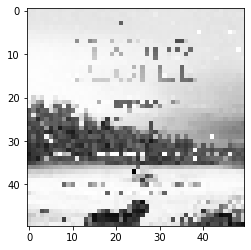

In [34]:
import matplotlib.pyplot as plt

plt.imshow(training_data[0][0],cmap='gray')
plt.show()

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [89]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64, 128, 5)
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)
 

    

In [90]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [91]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()


X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [92]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

22


In [102]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))



BATCH_SIZE = 1
EPOCHS =30

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

205 22


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:02<00:00, 80.49it/s]


Epoch: 0. Loss: 0.2085614651441574


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:02<00:00, 83.53it/s]


Epoch: 1. Loss: 0.2069397270679474


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:02<00:00, 79.30it/s]


Epoch: 2. Loss: 0.20331698656082153


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 51.55it/s]


Epoch: 3. Loss: 0.22154541313648224


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:03<00:00, 54.24it/s]


Epoch: 4. Loss: 0.18192926049232483


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 49.87it/s]


Epoch: 5. Loss: 0.18514323234558105


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 47.35it/s]


Epoch: 6. Loss: 0.22259338200092316


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 44.52it/s]


Epoch: 7. Loss: 0.17269259691238403


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 41.76it/s]


Epoch: 8. Loss: 0.31316709518432617


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 44.77it/s]


Epoch: 9. Loss: 0.18016040325164795


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:05<00:00, 40.01it/s]


Epoch: 10. Loss: 0.18698619306087494


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 23.61it/s]


Epoch: 11. Loss: 0.37178441882133484


100%|██████████████████████████████████████████████████████████████████████████████| 205/205 [1:45:36<00:00, 30.91s/it]


Epoch: 12. Loss: 0.20151886343955994


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:08<00:00, 23.66it/s]


Epoch: 13. Loss: 0.5467575192451477


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 44.35it/s]


Epoch: 14. Loss: 0.7373092770576477


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 46.88it/s]


Epoch: 15. Loss: 0.0052511440590023994


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 45.76it/s]


Epoch: 16. Loss: 0.017802990972995758


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 46.12it/s]


Epoch: 17. Loss: 0.5946747660636902


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 45.08it/s]


Epoch: 18. Loss: 5.949893420620356e-06


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:05<00:00, 40.57it/s]


Epoch: 19. Loss: 8.899632462089357e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:05<00:00, 40.55it/s]


Epoch: 20. Loss: 9.914438123814762e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 44.22it/s]


Epoch: 21. Loss: 2.0785080323548755e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 43.72it/s]


Epoch: 22. Loss: 1.1014500245210002e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 42.86it/s]


Epoch: 23. Loss: 1.618399352310007e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 43.69it/s]


Epoch: 24. Loss: 1.2209929423079302e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 41.05it/s]


Epoch: 25. Loss: 2.4862845293682767e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 27.14it/s]


Epoch: 26. Loss: 1.336576360699837e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:05<00:00, 35.21it/s]


Epoch: 27. Loss: 1.8719205741035694e-07


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 43.67it/s]


Epoch: 28. Loss: 3.29781619257119e-06


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:04<00:00, 45.26it/s]

Epoch: 29. Loss: 9.041004318532941e-07


In [103]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 182.30it/s]

Accuracy:  0.864
